# Logistic Regression

## Imports

In [275]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pickle
import os
import tqdm

## Data Preprocessing

In [276]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [277]:
PARENT = '/gdrive/MyDrive/Projects/ML_Models/'

### Loading Data

In [278]:
%cd /gdrive/MyDrive/Projects/ML_Models/

/gdrive/MyDrive/Projects/ML_Models


In [279]:
df =  pd.read_csv('dataset_LR.csv')

### Data Analysis

In [7]:
df.head()

,attr1,attr2,attr3,attr4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
df.describe()

,attr1,attr2,attr3,attr4,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Data Preprocessing

#### Trial

In [10]:
l = np.zeros((2, 137, 4))
l[0] = X[:137]
l[1] = X[137:274]

In [11]:
l[1].shape

(137, 4)

In [49]:
np.random.shuffle(X, seed)

In [50]:
X

array([[-0.62043 ,  0.5587  , -0.38587 , -0.66423 ],
       [ 4.7965  ,  6.9859  , -1.9967  , -0.35001 ],
       [-1.7344  ,  2.0175  ,  7.7618  ,  0.93532 ],
       ...,
       [ 3.9719  ,  1.0367  ,  0.75973 ,  1.0013  ],
       [ 4.1425  , -3.6792  ,  3.8281  ,  1.6297  ],
       [-1.005   ,  0.084831, -0.2462  ,  0.45688 ]])

In [42]:
def to_numpy_array(df):
    '''
    Splits the dataset into attributes/features and converts them to numpy arrays

    df = Dataset (pandas Dataframe)
    '''
    return np.array(df.iloc[:,:-1]), np.array(df.iloc[:,-1])

def divide(X, y, n=10):
    '''
    Divides the X and y data into 'n' parts
    
    X = Attribute values (Numpy Array)
    y = Labels (Numpy Array)
    n = No. of divides
    '''
    k = int(X.shape[0]/n)
    X_t = np.zeros((n, k, X.shape[1]))
    y_t = np.zeros((n, k))
    for i in range(0, n):
        X_t[i] = X[(i*k):((i+1)*k)]
        y_t[i] = y[(i*k):((i+1)*k)]
    
    return X_t, y_t

def split(X, y, train_size=0.7):
    '''
    Splits each of the 'n' parts into train and test data
    Returns X_train, y_train, X_test, y_test

    X = Attribute values (Numpy Array)
    y = Labels (Numpy Array)
    train_size = Ratio of train data
    '''

    X_t, y_t = divide(X, y, 10)

    train = int(train_size * X_t[0].shape[0])
    test = int((1-train_size) * X_t[0].shape[0])
    
    n=X_t.shape[0]
    X_train_out = np.zeros((n, train, X.shape[1]))
    X_test_out = np.zeros((n, test, X.shape[1]))
    y_train_out = np.zeros((n, train))
    y_test_out = np.zeros((n, test))


    for i in range(0, n):
        shuffler = np.random.permutation(X.shape[0])
        X_t = X[shuffler]
        y_t = y[shuffler]
        X_train_out[i] = X_t[0 : train]
        X_test_out[i] = X_t[train : train+test] 
        y_train_out[i] = y_t[0 : train]
        y_test_out[i] = y_t[train : train+test] 

    return X_train_out, y_train_out, X_test_out, y_test_out

#### Organized Class

In [280]:
class DataPreprocess():
    def __init__(self, df, n=10, train_size=0.7, standardize=False):
        self.df=df
        self.n=n
        self.standardize=standardize
        self.train_size = train_size
        self.X, self.y = self.to_numpy_array()
        self.X_train, self.y_train, self.X_test, self.y_test = self.split()

        if self.standardize:
            self.X_train_original, self.X_test_original = self.X_train, self.X_test
            self.means, self.stds = self.standard()
        
    def to_numpy_array(self):
        '''
        Splits the dataset into attributes/features and converts them to numpy arrays

        df = Dataset (pandas Dataframe)
        '''
        return np.array(self.df.iloc[:,:-1]), np.array(self.df.iloc[:,-1])

    def standard(self):
        means=[]
        stds=[]
        means = np.zeros((X_train.shape[0], X_train.shape[2]))
        stds = np.zeros((X_train.shape[0], X_train.shape[2]))
        for j in range(self.X_train.shape[0]):
            for i in range(self.X_train.shape[2]):
                means[j][i]=self.X_train[j][:,i].mean()
                stds[j][i]=self.X_train[j][:,i].std()
                self.X_train[j][:,i] = (self.X_train[j][:,i] - means[j][i]) / stds[j][i]
                self.X_test[j][:,i] = (self.X_test[j][:,i] - means[j][i]) / stds[j][i]
        return means, stds

    def shuffle_in_unison(self, X, y, i):
        r = np.random.RandomState(i)
        state = r.get_state()
        np.random.shuffle(X)
        np.random.set_state(state)
        np.random.shuffle(y)
        return X, y

    def split(self):
        '''
        Splits each of the 'n' randomly shuffled arraays into train and test data
        Returns X_train, y_train, X_test, y_test

        X = Attribute values (Numpy Array)
        y = Labels (Numpy Array)
        train_size = Ratio of train data
        '''

        X=self.X
        y=self.y
        n=self.n
        train_size=self.train_size

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train_out = np.zeros((n, train, X.shape[1]))
        X_test_out = np.zeros((n, test, X.shape[1]))
        y_train_out = np.zeros((n, train))
        y_test_out = np.zeros((n, test))


        for i in range(0, n):
            X_t, y_t = self.shuffle_in_unison(X, y, i)
            X_train_out[i] = X_t[0 : train]
            X_test_out[i] = X_t[train : train+test] 
            y_train_out[i] = y_t[0 : train]
            y_test_out[i] = y_t[train : train+test] 

        return X_train_out, y_train_out, X_test_out, y_test_out

In [281]:
dp = DataPreprocess(df, standardize=True)

In [282]:
dp.X_train.shape, dp.X_train[0].mean(), dp.X_train[0].std()

((10, 960, 4), 1.572815951552305e-17, 1.0)

In [309]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit_transform(dp.X_train)
scaler.fit(dp.X_test_original)
print(scaler.mean_, dp.means)

ValueError: ignored

#### Dump

In [110]:
file = open(os.path.join(PARENT, 'DataPreProcess.pickle'), 'wb')
pickle.dump(dp, file)
file.close()

In [226]:
file = open(os.path.join(PARENT, 'DataPreProcessStandard.pickle'), 'wb')
pickle.dump(dp, file)
file.close()

#### Load

In [283]:
file = open(os.path.join(PARENT, 'DataPreProcess.pickle'), 'rb')
dp = pickle.load(file)
file.close()

In [284]:
file = open(os.path.join(PARENT, 'DataPreProcessStandard.pickle'), 'rb')
dp = pickle.load(file)
file.close()

## Model

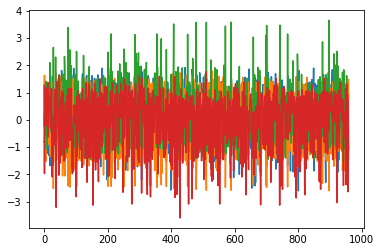

In [231]:
plt.plot(dp.X_train[0])

In [299]:
class LogReg():

    def __init__(self, learning= 'GD'):
        self.w = None
        self.b = None
        self.learning=learning        
  
    def perceptron(self, X):
        return np.dot(X, self.w.T) + self.b

    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def grad_w(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)

    def mean_squared_error(self, y_pred, y):
        return sum([(y1-y2)**2 for y1, y2 in zip(y_true, y_pred)])
        #/len([(y1-y2)**2 for y1, y2 in zip(y_true, y_pred)])
    
    def shuffle_in_unison(self, X, y):
        r = np.random.RandomState()
        state = r.get_state()
        np.random.shuffle(X)
        np.random.set_state(state)
        np.random.shuffle(y)
        return X, y

    def fit(self, X, Y, epochs = 1, learning_rate = 1, batches=1, intialize = False, display_loss=False):
    
        #intialize
        if intialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss={}
            accuracy={}

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0

            if self.learning == 'GD':
                print('GD')


            if self.learning == 'SGD':
                self.shuffle_in_unison(X, Y)
            
            for x, y in zip(X, Y):
                dw += self.grad_w(x,y)
                db += self.grad_b(x,y)
            self.w -= learning_rate * dw
            self.b -= learning_rate * db

            # if display_loss and i%50==0:
            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i] = self.mean_squared_error(Y_pred,Y)
                #accuracy[i] = self.accuracy(Y_pred, Y)

        if display_loss:
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            plt.show()


    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        
    return np.array(Y_pred)

    def cross_val(self, data, k, learning_rate):
        '''
        Performs k-fold validation on the given data.
        
        Parameters:
            data
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0

        print('Total of 10 Splits:')        
        for i in range(k):
            
            print('Split', i,': ')
            X_train, X_test, Y_train, Y_test = data.X_train[i], data.X_test[i], data.y_train[i], data.y_test[i]         
            print('Training the Model...')
            self.fit(X_train, Y_train, epochs = 2000, learning_rate=1 , intialize = True, display_loss=True)
            print('Trained the Model.')            
            y_pred = self.predict(X_test)
            metric_dict = self.report(y_pred, Y_test)
            print('The most important feature is \'attr\'', np.argmax(GD.w), 'with weight', self.w[0][np.argmax(self.w)])
            
            TP+=metric_dict['TP']
            TN+=metric_dict['TN']
            FP+=metric_dict['FP']
            FN+=metric_dict['FN']
            Total+=metric_dict['Total']
            accuracy+=metric_dict['Accuracy']
            precision+=metric_dict['Precision']
            recall+=metric_dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
        
    
    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.predict(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()

## Gradient Descent

In [236]:
GD = LogReg(learning='GD')

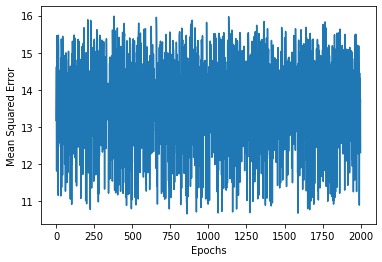

1.1100392833701043 attr 1


In [240]:
GD.fit(dp.X_train[0], dp.y_train[0], epochs=2000, learning_rate=0.15, display_loss=True)
print(GD.w[0][np.argmax(GD.w)], 'attr', np.argmax(GD.w))

Classification Report
                              
TP                          82
TN                         129
FP                          84
FN                         116
Total                      411
Accuracy      0.51338199513382
Recall     0.41414141414141414
Precision   0.4939759036144578


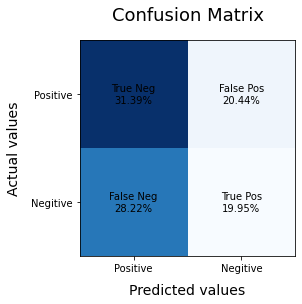

In [242]:
GD.evaluate(dp.X_test[0], dp.y_test[0])

## Stochastic Gradient Descent

In [300]:
GD1 = LogReg(learning='SGD')

In [302]:
dp.y_train

array([[1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

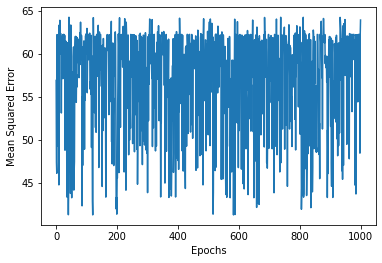

0.9420022812844844 attr 2


In [301]:
GD1.fit(dp.X_train[0], dp.y_train[0], epochs=1000, learning_rate=0.5, intialize=True, display_loss=True)
print(GD1.w[0][np.argmax(GD1.w)], 'attr', np.argmax(GD1.w))

In [296]:
GD1.evaluate(dp.X_test[0], dp.y_test[0])

ZeroDivisionError: ignored

Total of 10 Splits:
1st Split : 
Training the Model...


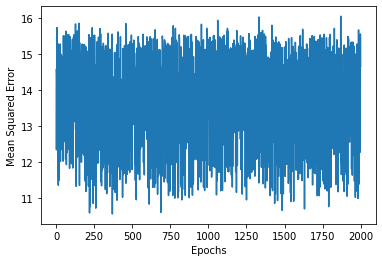

Trained the Model.
The most important feature is 'attr' 1 with weight 1.0412213394943564
Classification Report
                              
TP                          11
TN                         206
FP                           7
FN                         187
Total                      411
Accuracy    0.5279805352798054
Recall     0.05555555555555555
Precision   0.6111111111111112


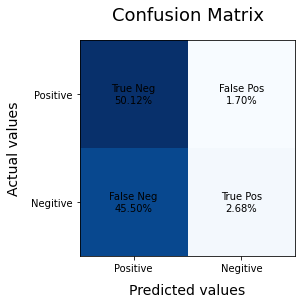

1st Split : 
Training the Model...


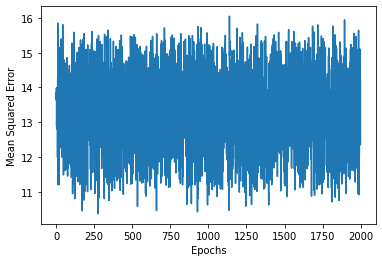

Trained the Model.
The most important feature is 'attr' 1 with weight 0.8724984880232083
Classification Report
                              
TP                         132
TN                          40
FP                         205
FN                          34
Total                      411
Accuracy   0.41849148418491483
Recall      0.7951807228915663
Precision   0.3916913946587537


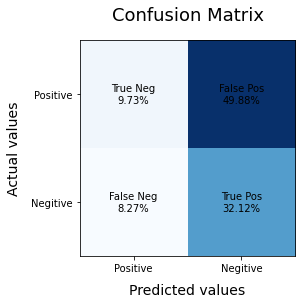

1st Split : 
Training the Model...


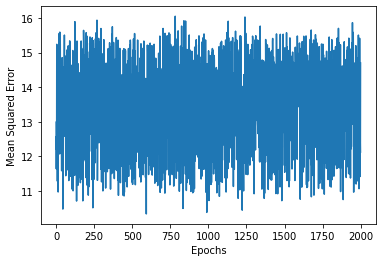

Trained the Model.
The most important feature is 'attr' 1 with weight 1.5508865610114024
Classification Report
                              
TP                          62
TN                         148
FP                          88
FN                         113
Total                      411
Accuracy    0.5109489051094891
Recall     0.35428571428571426
Precision  0.41333333333333333


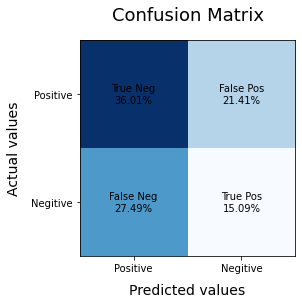

1st Split : 
Training the Model...


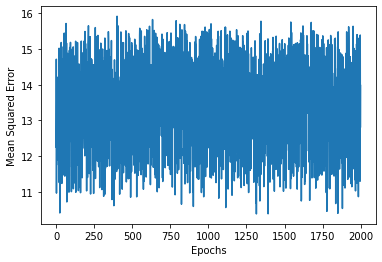

Trained the Model.
The most important feature is 'attr' 1 with weight 2.1593130821414595
Classification Report
                              
TP                          95
TN                         125
FP                         114
FN                          77
Total                      411
Accuracy    0.5352798053527981
Recall      0.5523255813953488
Precision  0.45454545454545453


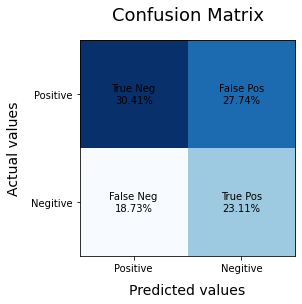

1st Split : 
Training the Model...


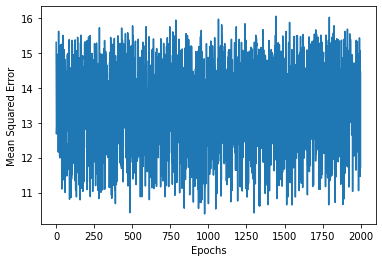

Trained the Model.
The most important feature is 'attr' 1 with weight 1.3298832791195676
Classification Report
                              
TP                         126
TN                          81
FP                         153
FN                          51
Total                      411
Accuracy    0.5036496350364964
Recall       0.711864406779661
Precision  0.45161290322580644


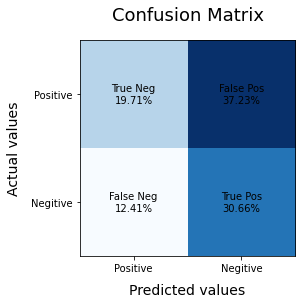

1st Split : 
Training the Model...


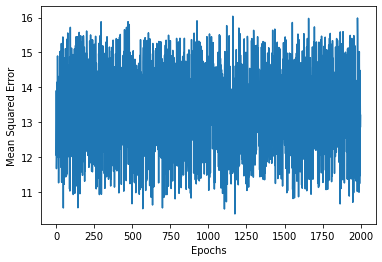

Trained the Model.
The most important feature is 'attr' 1 with weight 0.06688464954029891
Classification Report
                              
TP                           6
TN                         233
FP                           8
FN                         164
Total                      411
Accuracy    0.5815085158150851
Recall     0.03529411764705882
Precision  0.42857142857142855


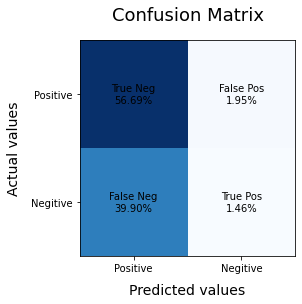

1st Split : 
Training the Model...


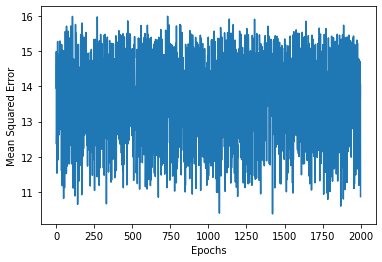

Trained the Model.
The most important feature is 'attr' 1 with weight 1.5119552952446265
Classification Report
                             
TP                        151
TN                         57
FP                        153
FN                         50
Total                     411
Accuracy   0.5060827250608273
Recall     0.7512437810945274
Precision  0.4967105263157895


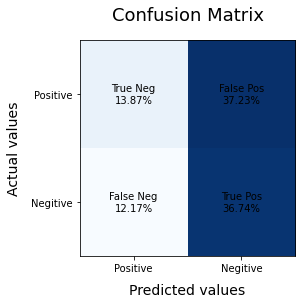

1st Split : 
Training the Model...


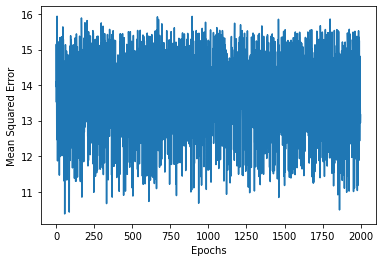

Trained the Model.
The most important feature is 'attr' 1 with weight 1.0952181562404686
Classification Report
                              
TP                          80
TN                         125
FP                          85
FN                         121
Total                      411
Accuracy   0.49878345498783455
Recall     0.39800995024875624
Precision  0.48484848484848486


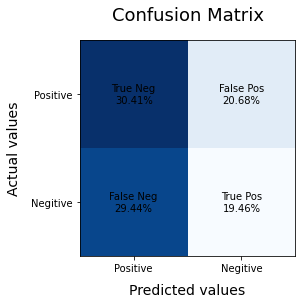

1st Split : 
Training the Model...


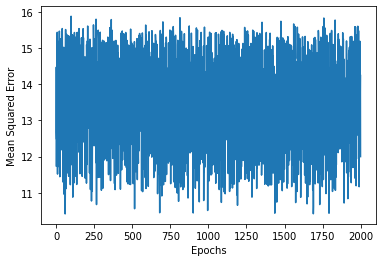

Trained the Model.
The most important feature is 'attr' 1 with weight 0.7037506258833173
Classification Report
                             
TP                        104
TN                         92
FP                        138
FN                         77
Total                     411
Accuracy   0.4768856447688564
Recall      0.574585635359116
Precision  0.4297520661157025


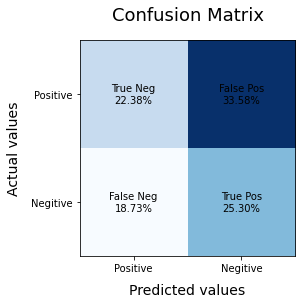

1st Split : 
Training the Model...


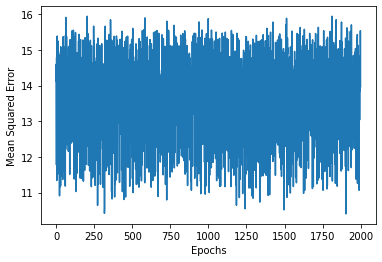

Trained the Model.
The most important feature is 'attr' 1 with weight 0.8375497309377584
Classification Report
                              
TP                          28
TN                         197
FP                          22
FN                         164
Total                      411
Accuracy    0.5474452554744526
Recall     0.14583333333333334
Precision                 0.56


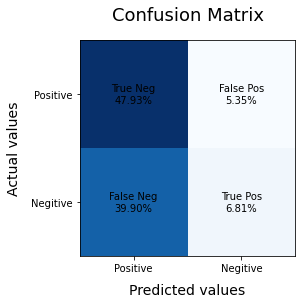

Final Classification Report
                              
TP                        79.5
TN                       130.4
FP                        97.3
FN                       103.8
Total                    411.0
Accuracy     0.510705596107056
Recall     0.43741787985906366
Precision  0.47221767027258643


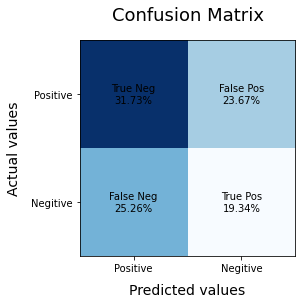

In [261]:
GD1.cross_val(dp, 10, 0.1)

In [262]:
GD1.w

array([[-0.62759157,  0.83754973, -0.13991815, -0.9639057 ]])

In [266]:
dp.X_train[0][0], dp.y_train[0][0]

(array([-0.06485732, -0.05793498, -0.65510726,  0.28963293]), 1.0)

In [267]:
dw =0
dw+=GD1.grad_w(dp.X_train[0][0], dp.y_train[0][0])

In [268]:
dw

array([ 0.00394631,  0.00352511,  0.03986067, -0.01762301])

In [269]:
GD1.perceptron(dp.X_train[0][0])

array([-2.5803648])

In [ ]:
def predict(row, coefficients):
	yhat = coefficients[0]
	for i in range(len(row)-1):
		yhat += coefficients[i + 1] * row[i]
	return 1.0 / (1.0 + exp(-yhat))